In [1]:
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import s3fs
import cftime
import intake
import numpy as np
from pyproj import Transformer
from datetime import datetime
%load_ext autoreload
%autoreload 2

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(
    variable_id='so', source_id='UKESM1-0-LL', table_id='Omon', 
    member_id='r2i1p1f2', 
    experiment_id='historical'
)

cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708


In [3]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [4]:
dataset_list = list(dset_dict.keys())
dset = dset_dict[dataset_list[0]].isel(time=-6,lev=0).squeeze()
dset

<xarray.Dataset>
Dimensions:             (i: 360, j: 330, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    lev                 float64 0.5058
    lev_bnds            (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    time                object 2014-07-16 00:00:00
    time_bnds           (bnds) object dask.array<chunksize=(2,), meta=np.ndarray>
    member_id           <U8 'r2i1p1f2'
Dimensions without coordinates: bnds, vertices
Data variables:
    so                  (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
Attributes: (12/51)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   113400.0
    cmor_version:            3.4.0
    ...                      ...
    variable_id:             so
    variant_label:           r2i1p1f2
    netcdf_tracking_ids:     hdl:21.14100/38ef9b7c-502c-422e-95e0-483cfd2eafc...
    version_id:              v20190708
    intake_esm_varname:      ['so']
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

In [43]:
sssA = dset.so.where(dset.latitude>60, drop=True).compute()
sssA.longitude[0].values.round()

array([  98.,   99.,  100.,  101.,  102.,  102.,  103.,  104.,  105.,
        106.,  107.,  108.,  109.,  110.,  111.,  112.,  112.,  113.,
        114.,  115.,  116.,  117.,  118.,  119.,  120.,  121.,  122.,
        123.,  124.,  125.,  126.,  127.,  128.,  129.,  130.,  131.,
        132.,  133.,  134.,  135.,  136.,  137.,  138.,  140.,  141.,
        142.,  143.,  144.,  145.,  146.,  147.,  148.,  149.,  151.,
        152.,  153.,  154.,  155.,  156.,  157.,  159.,  160.,  161.,
        162.,  163.,  164.,  165.,  167.,  168.,  169.,  170.,  171.,
        172.,  174.,  175.,  176.,  177.,  178.,  179., -180., -178.,
       -177., -176., -175., -174., -173., -172., -170., -169., -168.,
       -167., -166., -165., -164., -163., -162., -161., -160., -159.,
       -158., -156., -155., -154., -153., -152., -151., -150., -149.,
       -148., -147., -146., -145., -144., -143., -142., -141., -140.,
       -140., -139., -138., -137., -136., -135., -134., -133., -132.,
       -131., -130.,

#### Correct longitudes for plotting

problem due to longitudes 'wrapping around' and go from -180 to +180, 
leads to issue with pcolormesh trying to make a quadrilateral with corners -180 and 180

from https://stackoverflow.com/questions/40009652/using-python-basemap-pcolormesh-with-non-monotonic-longitude-jumps


In [40]:
lonPlt = np.unwrap(sssA.longitude, period=360)
lonPlt

array([[ 97.92025 ,  98.81576 ,  99.71206 , ..., 406.28793 , 407.18423 ,
        408.07974 ],
       [ 97.76515 ,  98.653336,  99.54233 , ..., 406.45767 , 407.34668 ,
        408.23483 ],
       [ 97.603096,  98.48358 ,  99.364914, ..., 406.63507 , 407.51642 ,
        408.3969  ],
       ...,
       [ 74.48322 ,  74.52923 ,  74.57586 , ..., 431.42413 , 431.47076 ,
        431.51678 ],
       [ 73.88322 ,  73.91063 ,  73.93841 , ..., 432.06158 , 432.08936 ,
        432.1168  ],
       [ 73.29202 ,  73.301094,  73.31029 , ..., 432.6897  , 432.6989  ,
        432.70798 ]], dtype=float32)

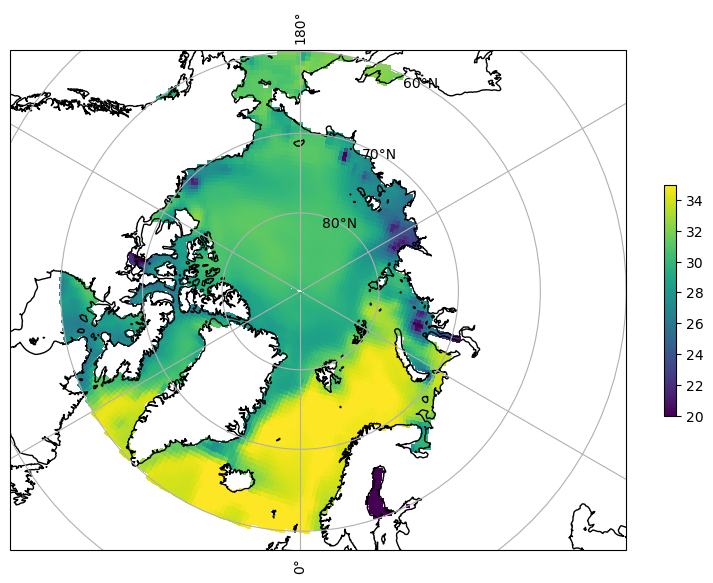

In [41]:
fig, ax = plt.subplots(figsize=(8,8),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()}
                       # subplot_kw={'projection':ccrs.PlateCarree()
                                  )

pl=ax.pcolormesh(lonPlt, sssA.latitude, sssA,
    vmin=20,vmax=35,
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
)
fig.colorbar(pl,shrink=0.3)


ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()